<a href="https://colab.research.google.com/github/johyunkang/python-ml-guide/blob/main/python_ml_perfect_guide_08_TextAnal_10%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%B6%84%EC%84%9D%EC%8B%A4%EC%8A%B5_%EC%BA%90%EA%B8%80MercariPriceSuggestionChallenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 10 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge

- Data
    - url : https://www.kaggle.com/c/mercari-price-suggestion-challenge/data
    - data file : train.tsv
    

- 필드 속성
    - traind_id : 데이터id
    - name : 제품명
    - item_condition_id : 판매자가 제공하는 제품 상태
    - category_name : 카테고리명
    - brand_name : 브랜드 이름
    - price : 제품가격. 예측을 위한 타깃 속성
    - shipping : 배송비 무료 여부, 1이면 무료(판매자가 지불), 0이면 유료 (구매자가 지불)
    - item_description : 제품에 대한 설명
    

#### 데이터 전처리

In [ ]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('data/text-anal/10-MercariPriceSuugestionChallenge/train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [ ]:
# NULL 여부 확인
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price'>

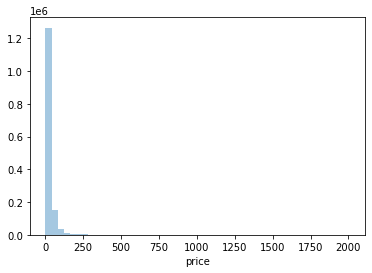

In [ ]:
# brand_name 은 Null 값을 많이 가지고 있음. 전체 1,482,535건 중 849,853건만 Not Null 임
# category 는 6300 건의 Null 데이터
# item_description 은 4건 null

# price 컬럼의 분포도 살펴보겠음
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6, 4))
sns.distplot(y_train_df, kde=False) # kde (Kernel Density Estimator; 커널밀도추정, True 면 스무딩해서 그려줌)

<AxesSubplot:xlabel='price', ylabel='Density'>

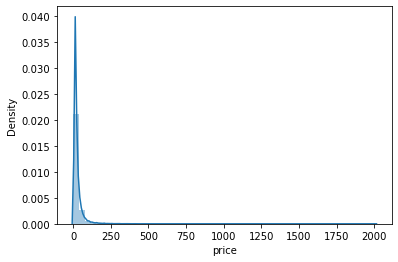

In [ ]:
sns.distplot(y_train_df, kde=True) # kde (Kernel Density Estimator; 커널밀도추정)

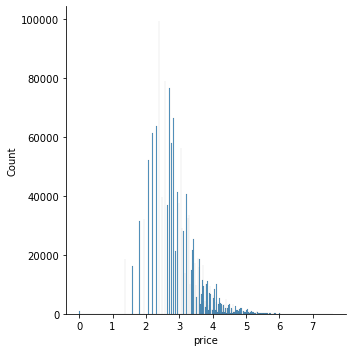

In [ ]:
# price 컬럼을 로그 값으로 변환한 뒤 분포도 다시 살펴봄
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.displot(y_train_df, kde=False)

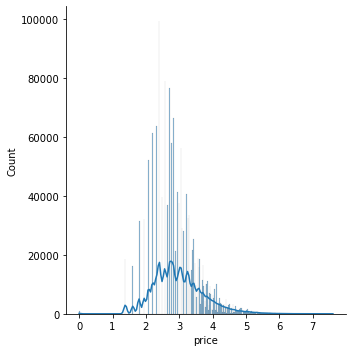

In [ ]:
sns.displot(y_train_df, kde=True)

In [ ]:
# 로그로 변환 시 price 값이 비교적 정규분포에 가깝기에 price 값을 로그로 변환하겠음
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head()

0    2.397895
1    3.970292
2    2.397895
3    3.583519
4    3.806662
Name: price, dtype: float64

In [ ]:
# 다른 피처, shipping 과 item_condition_id 값의 유형
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('\n\n item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64


 item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [ ]:
# shipping 컬럼은 비교적 균일
# item_condition_id 는 판매자가 제공한느 제품 상태로서 각 값의 의미는 기재되어 있지 않음. 1, 2, 3 값이 주를 이룸

# item_description의 Null 컬럼은 별로 없지만, 별도 설명이 없는 경우 'No description yet' 값으로 돼 있음
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

In [ ]:
# 'No description yet' 값이 82,489 건. Null 과 마찬가지로 적절한 값으로 변경해야함

- category_name을 살펴보겠음
    - category_name 은 '/'로 분리된 카테고리를 하나의 문자열로 나타내고 있음
    - Men/Tops/T-shirts 는 대분류 Men, 중분류 Tops, 소분류 T-shirts
    - category_name은 텍스트이므로 tokenizer를 '/'로 하여 단어를 분리해 벡터화 할 수 있음.
    - 그러나 여기서는 '/'를 기준으로 단어를 토큰화해 각각 별도의 피처로 저장하고 이를 이용해 알고리즘을 학습시키겠음
    - '/'를 기준으로 분리하기 위해 별도의 split_cat() 함수 생성

In [ ]:
# apply lambda 에서 호출되는 대, 중, 소 분할 함수 생성. 대, 중, 소 값을 리스트로 반환
def split_cat(category_name) :
    try :
        return category_name.split('/')
    except :
        return ['Other_Null', 'Other_Null', 'Other_Null'] # category_name 이 Null 일 경우 이를 위해 대, 중, 소 모두 Other_Null 반환
    
# 위의 split_cat 을 apply lambda 에서 호출해 대, 중, 소 칼럼을 mercari_df 에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
    zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중 소 분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수 :\n', mercari_df['cat_jung'].nunique())
print('소분류 개수 :\n', mercari_df['cat_so'].nunique())

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 개수 :
 114
소분류 개수 :
 871


- brand_name, category_name, item_description 의 Null 은 일괄적으로 'Other_Null' 로 변경

In [ ]:
fillna_str = 'Other_Null'
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value=fillna_str)
mercari_df['category_name'] = mercari_df['category_name'].fillna(value=fillna_str)
mercari_df['item_description'] = mercari_df['item_description'].fillna(value=fillna_str)

# 각 컬럼별 Null 값 건수 확인. 모두 0 나와야 함
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

#### 피처 인코딩과 피처 벡터화

- 선형회귀의 경우 **원-핫 인코딩 적용이 훨씬 선호되므로** 인코딩할 피처는 모두 원-핫 인코딩을 적용하겠음
- 피처 벡터화의 경우는 짧은 텍스트는 Count 기반의 벡터화, 긴 텍스트는 TD-IDF 기반의 벡터화를 적용

- 첫 번째로 검토할 컬럼은 brand_name

In [ ]:
print('brand name 의 유형 건수:', mercari_df['brand_name'].nunique())
print('brand name sample 5건:\n', mercari_df['brand_name'].value_counts()[:5])

brand name 의 유형 건수: 4810
brand name sample 5건:
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


- brand_name 의 경우 대부분 명료한 문자열로 돼 있어, 별도 피처 벡터화 없이 인코딩을 적용하겠음
- brand_name 의 종류가 4810건으로 원-핫 인코딩 변환하기에 다소 많아 보이나, 본 예제의 ML 모델 구축상 큰 문제는 없음

- 상품병을 의미하는 name 속성이 어떤 유형으로 돼 있는지 건수와 상품명 7개만 출력

In [ ]:
print('name 의 종류 개수:', mercari_df['name'].nunique())
print('name sample 7건:\n', mercari_df['name'].value_counts()[:7])

name 의 종류 개수: 1225273
name sample 7건:
 Bundle                 2232
Reserved                453
Converse                445
BUNDLE                  418
Dress                   410
Coach purse             404
Lularoe TC leggings     396
Name: name, dtype: int64


- name 의 속성 종류가 무려 1,225,273 종류나 됨.
- 전체 데이터가 1,482, 535 개 이므로 거의 고유한 상품명을 가지고 있음
- name 속성은 유형이 매우 많고, 적은 단어 위주의 텍스트 형태로 돼 있으므로 Count 기반의 피처 벡터화를 적용

- category_name 컬럼은 이전에 전처리를 통해 대, 중, 소 분류 세 개의 컬럼인 cat_dae, cat_jung, cat_so 분리
- cat_dae, cat_jung, cat_so 컬럼도 원-핫 인코딩을 적용

- shipping 컬럼은 배송비 무료 여부로 0, 1 두 유형의 값을 가지고 있음
- item_condition_id 는 상품 상태로서 1, 2, 3, 4, 5 다섯가지 유형의 값을 가지고 있음
- shipping, item_condition_id 는 모두 원-핫 인코딩을 적용

- item_description은 상품에 대한 간단 설명으로 가장 긴 텍스트를 가지고 있음
- 해당 컬럼의 평균 문자열 크기와 2개 정도의 텍스트만 추출해 보겠음

In [ ]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

- 평균 문자열이 145자로 비교적 크므로 TF-IDF로 변환하겠음

- 이제 주요 컬럼을 인코딩 및 피처 벡터화 변화해 보겠음
- name : CountVectorizer
- item_description : TfidfVectorizer

In [ ]:
# name 속성에 대한 피처 벡터화
cnt_vec = CountVectorizer()
x_name = cnt_vec.fit_transform(mercari_df.name)

# item_description 에 대한 피처 벡터화
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), stop_words='english')
x_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name_vectorization shape:', x_name.shape)
print('item_description vectorization shape:', x_descp.shape)

name_vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


- CountVectorizer, TfidfVectorizer 가 fit_transform()을 통해 반환하는 데이터는 **희소행렬**
- 희소행렬 객체 변수인 x_name, x_descp를 새로 결합해 새로운 데이터 세트를 구성해야 하고
- 앞으로 인코딩 될 cat_dae, cat_jung, cat_so, brand_name, shipping, item_condition_id 도 모두 x_name, x_descp 와 결합 돼 ML 모델을 실행하는 기반 데이터 세트로 재구성되어야 함

- 이를 위해 인코딩 대상 컬럼도 밀집 행렬 형태가 아닌 희소 행렬 형태로 인코딩을 적용한 뒤, 함께 결합하도록 하겠음
- 사이킷런은 원-핫 인코딩을 위해 OneHotEncoder 와 LabelBinarizer 클래스를 제공
- 이 중 LabelBinarizer 클래스는 희소행렬 형태의 원-핫 인코딩 변환을 지원함
- 생성 시 **sparse_output=True** 로 파라미터를 설정해주기만 하면 됨
- 개별 컬럼으로 만들어진 **희소 행렬은 사이파이 패키지 sparse 모듈의 hstack() 함수를 이용해 결합**하겠음
- **hstack() 함수는 희소 행렬을 손쉽게 컬럼 레벨로 결합**할 수 있게 해줌

![sparse-hatck](https://user-images.githubusercontent.com/291782/193435461-6cf91939-a380-4aa9-9e47-695de8edd413.png)

- 먼저 인코딩된 대상 컬럼을 모두 LabelBinarizer 로 원-핫 인코딩 변환하겠음
- 다음 예제는 저자의 책에서 약 5분 정도 시간 걸림

In [ ]:
import time
from datetime import datetime
from sklearn.preprocessing import LabelBinarizer

# 수행 시간 설정 : 시작 시간 설정
now = datetime.now()
start = time.time() # 시작시간
print('시작시간:', datetime.now())

# brand_name, item_condition_id, shipping 각 피처들을 희소행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
x_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
x_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping = LabelBinarizer(sparse_output=True)
x_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
x_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
x_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
x_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

# 수행시간 설정 : 종료 시간 설정
print('수행시간 (sec):', time.time() - start)
print('종료시간:', datetime.now())


시작시간: 2022-10-04 23:42:11.390443
수행시간 (sec): 139.3782229423523
종료시간: 2022-10-04 23:44:30.768666


- 제대로 변환 되었는지 생성된 인코딩 데이터 세트의 타입과 shape을 살펴 보겠음

In [ ]:
print(type(x_brand), type(x_item_cond_id), type(x_shipping))
print('x_brand shape:{0}, x_item_cond_id shape:{1}'.format(x_brand.shape, x_item_cond_id.shape))
print('x_shipping shape:{0}, x_cat_dae shape:{1}'.format(x_shipping.shape, x_cat_dae.shape))
print('x_cat_jung shape:{0}, x_cat_so shape:{1}'.format(x_cat_jung.shape, x_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
x_brand shape:(1482535, 4810), x_item_cond_id shape:(1482535, 5)
x_shipping shape:(1482535, 1), x_cat_dae shape:(1482535, 11)
x_cat_jung shape:(1482535, 114), x_cat_so shape:(1482535, 871)


- 인코딩 변환된 데이터 세트가 CSR 형태로 변환된 csr_matrix 타입임
- brand_name 컬럼의 경우 값의 유형이 4810개이므로 이를 원-핫 인코딩으로 변환한 x_brand_shape 의 경우 4810개의 인코딩 컬럼을 가지게 되었음
- 인코딩 컬럼이 매우 많이 생겼지만, 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의 매우 많은 컬럼과 함께 결합되므로 크게 문제될 것은 없음

- 이번에는 피처 벡터화 변환된 데이터 세트와 희소 인코딩 변환된 데이터 세트를 hstack()을 이용해 모두 결합해 보겠음
- 만들어진 결합 데이터가 비교적 많은 메모리를 잡아먹기 때문에 PC에서 메모리 오류가 발생할 수 있기에 **del '객체 변수망' 과 gc.collect()**로 결합 데이터를 메모리에서 삭제

In [ ]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (x_name, x_descp, x_brand, x_item_cond_id, \
                     x_shipping, x_cat_dae, x_cat_jung, x_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
x_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(x_features_sparse), x_features_sparse.shape)



<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


In [ ]:
# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 메모리에서 삭제
del x_features_sparse
gc.collect()

80

- hstack() 으로 결합한 데이터 세트는 csr_matrix 타입이며, 총 161,569개의 피처를 가지게 되었음
- 이제 이렇게 만들어진 데이터 세트에 회귀를 적용해 price 값을 예측할 수 있도록 모델을 만들 차례임

#### 릿지회귀모델 구축 및 평가

- 예측 성능을 비교하면서 테스트를 수행할 것이므로 수행에 필요한 로직을 함수화하겠음
- 모델을 평가(Evaluation)하는 로직을 함수화
- 적용할 지표는 캐글에서 제시한 RMSLE (Root Mean Square Logarithmic Error) 방식으로 하겠음
- **RMSLE**는 **RMSE**와 유사하나 오류 값에 로그를 취해 RMSE를 구하는 방식
- 낮은 가격보다 높은 가격에서 오류가 발생할 경우 오류 값이 더 커지는 것을 억제하기 위해서 이 방식을 도입

$\epsilon = \displaystyle \sqrt {\dfrac {1}{n} \sum_{i=1}^n (log(p_i + 1) - log(\alpha_i + 1))^2}$

- 별도의 **RMSLE**를 구하는 함수를 **rmsle((y, y_pred))** 로 생성하겠음
- 학습할 모델이 사용할 price 값은 **로그 값으로 변환된 price 값**이므로, 예측도 당연히 로그로 변환한 데이터 값 수준의 price 값을 예측할 것 임
- 따라서 예측된 price 값은 다시 로그의 역변환인 지수(Exponential) 변환을 수행해 원복해야함
- 이렇게 원복된 데이터를 기반으로 RMSLE를 적용할 수 있도록 **evaluate_org_price(y_test, preds)** 함수를 생성

In [ ]:
def rmsle(y, y_pred) :
    # underflow, overflow 를 막기 위해 log 가 아닌 log1p로 rmsle 계산
    return np.sqrt( np.mean( np.power( np.log1p(y) - np.log1p(y_pred), 2) ) )

def evaluate_org_price(y_test, preds) :
    
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result


- 학습용 데이터를 생성하고, 모델을 학습 / 예측하는 로직을 별도의 함수로 만들겠음
- model_train_predict() 함수는 model 인자로 사이킷런의 회귀 estimator 객체를, matrix_list 인자로 최종 데이터 세트로 결합할 희소 행렬 리스트를 가짐

In [ ]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list) :
    # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
    x = hstack(matrix_list).tocsr()
    
    x_train, x_test, y_train, y_test = train_test_split(x, mercari_df['price'], 
                                                        test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    
    del x, x_train, x_test, y_train
    gc.collect()
    
    return preds, y_test

- 함수 수행 전 Mercari 상품 가격 예측에 item_description 과 같은 텍스트 형태의 속성이 얼마나 영향을 미치는지 알아보겠음
- item_description 속성 피처 벡터화 데이터가 포함 / 비포함 되었을 때 예측 성능을 비교해 보겠음

In [ ]:
linear_model = Ridge(solver='lsqr', fit_intercept=False)

sparse_matrix_list = (x_name, x_brand, x_item_cond_id, 
                     x_shipping, x_cat_dae, x_cat_jung, x_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (x_descp, x_name, x_brand, x_item_cond_id,
                     x_shipping, x_cat_dae, x_cat_jung, x_cat_so)

linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:', evaluate_org_price(y_test, linear_preds))


Item Description을 제외했을 때 rmsle 값: 0.5021634408234568
Item Description을 포함한 rmsle 값: 0.47122035359384046


- Item Description 을 포함했을 떄 rmsle 값이 많이 감소했음
- Item Description 영향이 중요함을 알 수 있음

#### LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가

- LightGBM 을 이용해 회귀를 수행한 뒤, 위에서 구한 릿지 모델 예측값과 LightGBM 모델 예측값을 앙상블(Ensemble) 방식으로 섞어서 최종 회귀 예측값을 평가하겠음

In [ ]:
#!pip install lightgbm  # 아래 lightgbm 수행을 위해 lightgbm 패키지 설치

In [ ]:
from lightgbm import LGBMRegressor

import time
from datetime import datetime

# 수행 시간 설정 : 시작 시간 설정
now = datetime.now()
start = time.time() # 시작시간
print('시작시간:', datetime.now())

sparse_matrix_list = (x_descp, x_name, x_brand, x_item_cond_id,
                     x_shipping, x_cat_dae, x_cat_jung, x_cat_so)


# n_estimators= 200 수행시간 : 473초.
'''
시작시간: 2022-10-05 00:13:58.799692
LightGBM rmsle 값: 0.4565182126498302
수행시간 (sec): 473.29084753990173
종료시간: 2022-10-05 00:21:52.090540
'''
lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)

print('LightGBM rmsle 값:', evaluate_org_price(y_test, lgbm_preds))

# 수행시간 설정 : 종료 시간 설정
print('수행시간 (sec):', time.time() - start)
print('종료시간:', datetime.now())

시작시간: 2022-10-05 00:13:58.799692
LightGBM rmsle 값: 0.4565182126498302
수행시간 (sec): 473.29084753990173
종료시간: 2022-10-05 00:21:52.090540


- 앞 예제의 Ridge 보다 예측 성능이 조금 더 나아졌음
- 이렇게 구한 LightGBM 결과값과 위에서 구한 Ridge 예측 결괏값을 서로 앙상블해 최종 예측 결괏값을 도출하겠음
- **LightGBM 결과값에 0.45를 곱하고, Ridge 결과값에 0.55를 곱한 값을 서로 합해 최종 예측 결과값**으로 하겠음
- (0.45와 0.55의 비율은 저자 임의 산정. 최적의 결과값을 도출하도록 배합 비율을 여러 가지로 해서 직접 수행해 보기 바람)
- Ridge 예측 데이터 세트인 linear_preds 에 일괄적으로 0.55를 곱하고, LightGBM 예측 세트인 lgbm_preds 에 일괄적으로 0.45를 곱한 뒤 합한 결과 데이터 세트로 예측 성능을 다시 측정해 보겠음

In [ ]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LigthGBM 과 Ridge를 앙상블한 최종 예측값:', evaluate_org_price(y_test, preds))

LigthGBM 과 Ridge를 앙상블한 최종 예측값: 0.45048177897380093


- 간단한 앙상블 방식으로 예측 성능을 더 개선했음
- 완료